# Exercise 4: Logistic Regression, Bayes and EM

In this assignment you will implement several algorithms as learned in class.

## Read the following instructions carefully:

1. This jupyter notebook contains all the step by step instructions needed for this exercise.
2. Write **efficient vectorized** code whenever possible. Some calculations in this exercise take several minutes when implemented efficiently, and might take much longer otherwise. Unnecessary loops will result in point deduction.
3. You are responsible for the correctness of your code and should add as many tests as you see fit. Tests will not be graded nor checked.
4. Write your functions in this notebook only. **Do not create Python modules and import them**.
5. You are allowed to use functions and methods from the [Python Standard Library](https://docs.python.org/3/library/) and [numpy](https://www.numpy.org/devdocs/reference/) and pandas. 
6. Your code must run without errors. During the environment setup, you were given a specific version of `numpy` to install (1.15.4). Changes of the configuration we provided are at your own risk. Any code that cannot run will not be graded.
7. Write your own code. Cheating will not be tolerated.
8. Submission includes this notebook only with the exercise number and your ID as the filename. For example: `hw4_123456789_987654321.ipynb` if you submitted in pairs and `hw4_123456789.ipynb` if you submitted the exercise alone.
9. Answers to qualitative questions should be written in **markdown** cells (with $\LaTeX$ support). Answers that will be written in commented code blocks will not be checked.

## In this exercise you will perform the following:
1. Implement Logistic Regression algorithm.
1. Implement EM algorithm.
1. Implement Navie Bayes algorithm that uses EM for calculating the likelihood.
1. Visualize your results.

# I have read and understood the instructions: *** YOUR ID HERE ***

In [1]:
import numpy as np
import pandas as pd
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import seaborn as sns
import random 

# make matplotlib figures appear inline in the notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Make the notebook automatically reload external python modules
%load_ext autoreload
%autoreload 2
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Function for ploting the decision boundaries of a model
# You will use it later
def plot_decision_regions(X, y, classifier, resolution=0.01):
    # setup marker generator and color map
    markers = ('.', '.')
    colors = ('blue', 'red')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=cl, 
                    edgecolor='black')

## Reading the data

In [3]:
training_set = pd.read_csv('training_set.csv')
test_set = pd.read_csv('test_set.csv')
X_training, y_training = training_set[['x1', 'x2']].values, training_set['y'].values
X_test, y_test = test_set[['x1', 'x2']].values, test_set['y'].values


## Visualizing the data
(2 points each - 8 points total)

Plot the following graphs for the training set:

For the first feature only:
1. For the first 1000 data points plot a histogram for each class on the same graph (use bins=20, alpha=0.5).
1. For all the data points plot a histogram for each class on the same graph (use bins=40, alpha=0.5).

For both features:
1. For the first 1000 data points plot a scatter plot where each class has different color
1. For all the data points plot a scatter plot where each class has different color

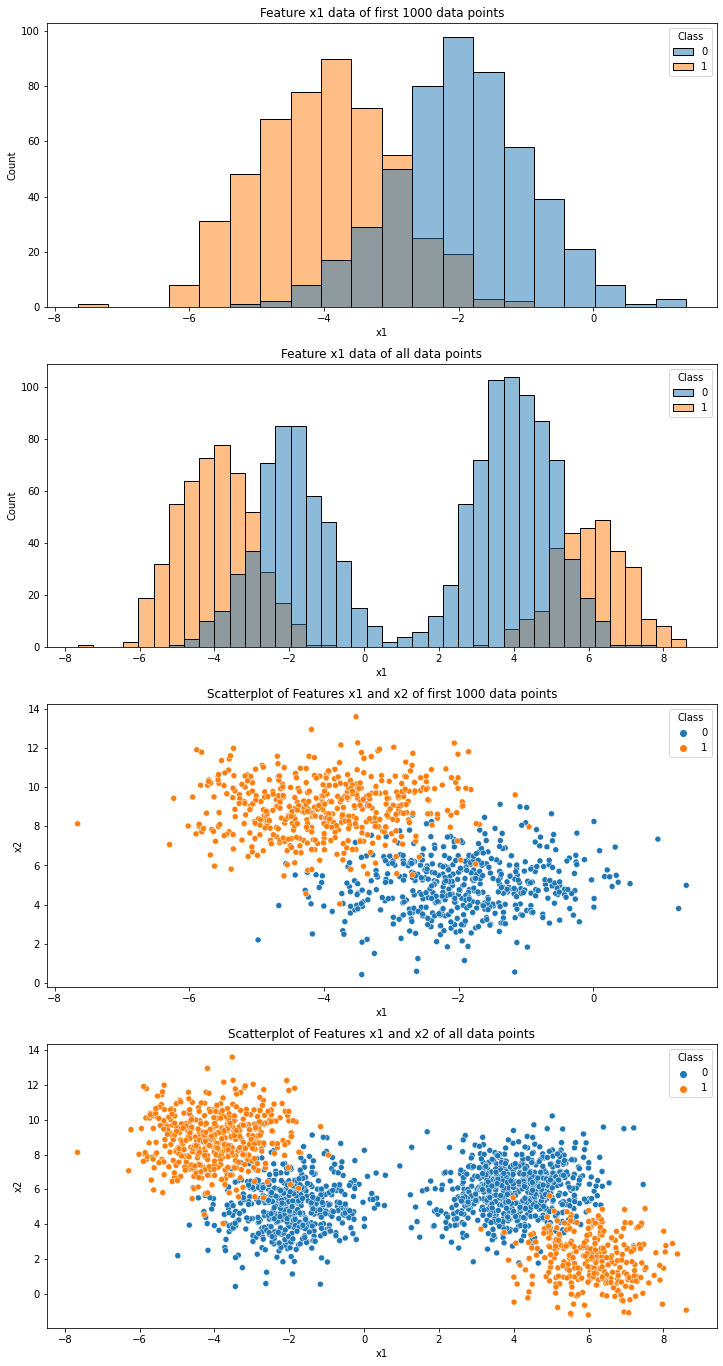

In [4]:
#### Your code here ####
fig, axis = plt.subplots(4,1, figsize = (12,24))
axis[0].set_title('Feature x1 data of first 1000 data points')
data = training_set.rename(columns = {'y': 'Class'})
sns.histplot(ax = axis[0] , data = data[0:1000], hue = 'Class', x = 'x1', bins = 20, alpha = 0.5)
axis[1].set_title('Feature x1 data of all data points')
sns.histplot(ax = axis[1], data = data, hue = 'Class', x='x1', bins = 40)
axis[2].set_title('Scatterplot of Features x1 and x2 of first 1000 data points')
sns.scatterplot(ax = axis[2], data= data[0:1000], hue = 'Class', x = 'x1', y='x2' )
axis[3].set_title('Scatterplot of Features x1 and x2 of all data points')
sns.scatterplot(ax = axis[3], data= data, hue = 'Class', x = 'x1', y='x2' )
plt.show()

## Logistic Regression

(15 Points)

Implement the Logistic Regression algorithm that uses gradient descent for finding the optimal theta vector. 

Where:
$$
h_\theta(x) = \frac{1}{1 + e^{-\theta^T x}}
$$

$$
J(\theta)=\frac{1}{m} \sum_{d=1}^{m} - y^{(d)}ln(h_\theta(x^{(d)}) - (1 - y^{(d)})ln(1 - h_\theta(x^{(d)})
$$

Your class should contain the following functions:
1. fit - the learning function
1. predict - the function for predicting an instance after the fit function was executed

\* You can add more functions if you think this is necessary

Your model should also store a list of the costs that you've calculated in each iteration

In [5]:
class LogisticRegressionGD(object):
    """
    Logistic Regression Classifier using gradient descent.

    Parameters
    ------------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset.
    eps : float
      minimal change in the cost to declare convergence
    random_state : int
      Random number generator seed for random weight
      initialization.
    """
    
    def __init__(self, features, eta=0.00005, n_iter=10000, eps=0.000001, random_state=45):
        self.eta = eta
        self.n_iter = n_iter
        self.eps = eps
        self.random_state = random.seed(random_state)
        n = features.shape[1]
        self.theta = np.random.random(n+1) #change to random
        self.cost_hist = []
    
    def sigmoid(self,X):
        return 1/(1+np.exp(-np.matmul(X, self.theta.T)))
    
    def fit(self, X, y):
        """ 
        Fit training data (the learning phase).
        Updating the theta vector in each iteration using gradient descent.
        Store the theta vector in an attribute of the LogisticRegressionGD object.
        Stop the function when the difference between the previous cost and the current is less than eps
        or when you reach n_iter.

        Parameters
        ----------
        X : {array-like}, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.

        """
        J_hist = []
        m = X.shape[0]
        for i in range(self.n_iter):
            X_new = np.ones((X.shape[0],(X.shape[1]+1)))
            X_new[:,1:] = X
            
            h_theta = self.sigmoid(X_new)
            J  = np.sum(-np.log(h_theta)*y - (1-y)*np.log(1-h_theta))/m
            J_hist.append(J)

            if i > 1 and (J_hist[i-1] - J_hist[i] < self.eps):
                self.cost_hist = J_hist
                return
  
            self.theta = self.theta - (self.eta*np.matmul( X_new.T,(h_theta-y)))

        self.cost_hist = J_hist
        return    
            
    def predict(self, X):
        """Return the predicted class label"""
        n = X.shape[0]
        if len(X.shape) == 1: # This means that X is a single instance
            X_n = np.ones((1,n+1))
            X_n[:,1:] = X
        else:
            X_n = np.ones((n,X.shape[1]+1))
            X_n[:,1:] = X

        h_theta = self.sigmoid(X_n)
        
        if isinstance(h_theta, np.ndarray):
            h_theta[h_theta > 0.5] = 1
            h_theta[h_theta  <= 0.5] = 0
        else:
            if h_theta > 0.5:
                h_theta = 1
            else:
                h_theta = 0

        return h_theta

    def get_cost_history(self):
        return self.cost_hist

In [6]:
def accuracy(model, x_test, y_test):
    total = x_test.shape[0]
    result=model.predict(x_test)
    correct = (result == y_test).sum()
    return correct/total

In [7]:
LOR = classifier = LogisticRegressionGD(features = X_training)
LOR.fit(X_training,y_training)
a = accuracy(LOR, X_test, y_test)
print(f'Accuracy of LOR model on test data: {a*100}%')

Accuracy of LOR model on test data: 80.4%


## Cross Validation

(5 points)

Use 5-fold cross validation in order to find the best eps and eta params from the given lists.

Shuffle the training set before you split the data to the folds.

In [8]:
#### Your code here ####
etas = [0.05, 0.005, 0.0005, 0.00005, 0.000005]
epss = [0.01, 0.001, 0.0001, 0.00001, 0.000001]

def cross_validation(etas, epss, k, df):
    folds = k
    best_eta = 0
    best_eps = 0
    max_accuracy = 0 

    random.seed(45)
    random.shuffle(df)

    group_size = df.shape[0]//folds
    lst = [df[i:i+group_size] for i in range(0,len(df)-group_size+1,group_size)]

    for i in etas:
        for j in epss:
            sum_accuracies = 0
            for k in range(folds):
                classifier = LogisticRegressionGD(features = X_training, eta=i, eps = j)
                lst_copy=lst.copy()
                # remove test set to use later for validation
                removed = lst_copy.pop(k)
                # concatenate train sets to train model on them
                lstmerged = np.concatenate(lst_copy)
                x = lstmerged[:,0:2]
                y = lstmerged[:,-1]
                classifier.fit(x,y)
                a = accuracy(classifier, removed[:,0:2], removed[:,-1])
                sum_accuracies += a
            avg_accuracies = sum_accuracies/folds

            if avg_accuracies > max_accuracy:
                max_accuracy = avg_accuracies
                best_eta = i 
                best_eps = j

            lst = [df[i:i+group_size] for i in range(0,len(df)-group_size+1,group_size)]
    return best_eta, best_eps, max_accuracy

best_eta, best_eps, max_accuracy = cross_validation(etas, epss, 5, training_set[['x1', 'x2', 'y']].copy().values)
print(f'Best eta: {best_eta}, Best eps: {best_eps}, with accuracy: {np.round(max_accuracy, 6)*100}%')  


Best eta: 5e-05, Best eps: 1e-05, with accuracy: 93.65%


## Normal distribution pdf

(2 Points)

Implement the normal distribution pdf 
$$
f(x;\mu,\sigma) = \frac{1}{\sigma\sqrt{2\pi}}e^{-\frac{1}{2}\big{(}\frac{x-\mu}{\sigma}\big{)}^2}
$$
Write an efficient vectorized code

In [18]:
#### Your code here ####
# data input should be a single feature  
def norm_pdf(data, mu, sigma):
    power = (-1/2)*((data - mu)/sigma)**2
    return np.exp(power)/np.sqrt(2*np.pi*(sigma**2))

#Output will return np array the same size as data

## Expectation Maximization

(15 Points)

Implement the Expectation Maximization algorithm for gaussian mixture model.

The class should hold the distribution params.

Use -log likelihood as the cost function:
$$
cost(x) = \sum_{d=1}^{m}-log(w * pdf(x; \mu, \sigma))
$$

\* The above is the cost of one gaussian. Think how to use the cost function for gaussian mixture.

Your class should contain the following functions:
1. init_params - initialize distribution params
1. expectation - calculating responsibilities
1. maximization - updating distribution params
1. fit - the learning function
1. get_dist_params - return the distribution params

\* You can add more functions if you think this is necessary

Don't change the eps params (eps=0.01)

When you need to calculate the pdf of a normal distribution use the function `norm_pdf` that you implemented above.

In [19]:
class EM(object):
    """
    Naive Bayes Classifier using Gauusian Mixture Model (EM) for calculating the likelihood.

    Parameters
    ------------
    k : int
      Number of gaussians in each dimension
    n_iter : int
      Passes over the training dataset in the EM proccess
    eps: float
      minimal change in the cost to declare convergence
    random_state : int
      Random number generator seed for random params initialization.
    """
    
    def __init__(self, k=1, n_iter=1000, eps=0.01, random_state=45):
        self.k = k
        self.n_iter = n_iter
        self.eps = eps
        self.random_state = random_state

    def init_params(self, data):
        """
        Initialize distribution params
        """
        random.seed(self.random_state)
        self.mu = np.mean(data)* np.ones(self.k)
        self.sigma = np.random.random(size = self.k)+0.5  #So that sigma is not too small because divsion by small number leads to Nan
        self.weights = np.array([1/self.k]*self.k) #sum must be 1
              
    def expectation(self, data):
        """
        E step - calculating responsibilities 
        """
        #Calculating responsibilities in vectorized form based on normal distribution
        summed = 0
        size = self.k
        up = np.zeros(data.shape)
        up = norm_pdf(data.reshape(-1,1),self.mu,self.sigma) * self.weights
        row_sums = np.sum(up, axis = 1, keepdims= True)
        return up / row_sums

    
    def maximization(self, data):
        """
        M step - updating distribution params
        """
        # Using the probabilities from expection to maximize parameters in this step
        respo = self.expectation(data)
        
        # updating all weights
        self.weights = np.average(respo,axis=0) 
        
        # new mu is the weighted average of observation with respect to responsibility
        m = data.shape[0]
        for i in range(self.k):
            self.mu[i] = np.matmul(respo[:,i].T,data) / (m * self.weights[i]) ## all data ??
            self.sigma[i] = np.sqrt((np.matmul(respo[:,i].reshape(-1,1).T, (data-self.mu[i])**2)) / (m * self.weights[i]))
        
    def fit(self, data):
        """ 
        Fit training data (the learning phase).
        Use init_params and then expectation and maximization function in order to find params 
        for the distribution. 
        Store the params in attributes of the EM object.
        Stop the function when the difference between the previous cost and the current is less than eps
        or when you reach n_iter.
        """
        #Initialize parameters from guess
        self.init_params(data)
        
        #Beginning log likelihood given estimated paramers
        cost_hist = []
        for i in range(self.n_iter):                
            cost = np.sum(-np.log(np.matmul(norm_pdf(data.reshape(-1,1),self.mu,self.sigma),self.weights.T)))
#             cost = np.sum(-1*np.log(self.likelihood(data)))
            cost_hist.append(cost)
            
            if i > 1 and (cost_hist[i-1] - cost_hist[i] < self.eps):
                return
            
            self.maximization(data)
        return
    
    def likelihood(self,X):
        #For single feature
        likelihood = 0.0
        for i in range(len(self.weights)):
            likelihood += self.weights[i] * norm_pdf(X, self.mu[i], self.sigma[i])
        return likelihood  
    
    def get_dist_params(self):
        return self.mu, self.sigma, self.weights, self.k

In [20]:
#Check EM on feature 1
# em = EM(k=2)
# df = X_training[:,0].copy().reshape(-1,1)
# em.fit(df)
# print('sigmas', em.sigma)
# print('means', em.mu)
# print('weights', em.weights)

## Naive Bayes

(15 Points)

Implement the Naive Bayes algorithm.

For calculating the likelihood use the EM algorithm that you implemented above to find the distribution params. With these params you can calculate the likelihood probability.

Calculate the prior probability directly from the training set.

Your class should contain the following functions:
1. fit - the learning function
1. predict - the function for predicting an instance (or instances) after the fit function was executed

\* You can add more functions if you think this is necessary


In [21]:
class NaiveBayesGaussian(object):
    """
    Naive Bayes Classifier using Gauusian Mixture Model (EM) for calculating the likelihood.

    Parameters
    ------------
    k : int
      Number of gaussians in each dimension
    random_state : int
      Random number generator seed for random params initialization.
    """
    
    def __init__(self, k=1, random_state=45):
        self.k = k
        random.seed(random_state)
        self.mu = np.array([])
        self.sigma = np.array([])
        self.weights = np.array([])
        self.prior = np.array([])
        self.no_classes = 0
        self.model = []        
        
    def fit(self, X, y):
        """ 
        Fit training data.

        Parameters
        ----------
        X : array-like, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.
        """
        #Determine number of classes
        self.no_classes = np.unique(y)
        total = len(y)
        self.prior = np.unique(y, return_counts=True)[1]/total
        
        for j in range(X.shape[1]):
            for i in range(len(self.no_classes)):                   
                Model = EM(self.k)
                new_X = X[y == i].copy()
                Model.init_params(new_X[:,j])
                Model.fit(new_X[:,j])
                
                #First model for x1 on class 0, second model for x1 on class 1
                #Third model for x2 on class 0, fourth model for x2 on class 1
                self.model.append(Model)
        
        return
    
    def get_instance_posterior(self, x):
        # Instances input are a 1X2 vector. 
        # According to the NB model, the features are conditionally independent given class so we can look at the EM of each feature
        # individually and then multiply between them to get the full instance posterior based  on class
        post0 = self.model[0].likelihood(x[:,0])*self.prior[0]* self.model[2].likelihood(x[:,1])*self.prior[0]
        post1 = self.model[1].likelihood(x[:,0])*self.prior[1]* self.model[3].likelihood(x[:,1])*self.prior[1]
        return post0,post1


    def predict(self, X):
        """Return the predicted class label"""
        post0, post1 = self.get_instance_posterior(X)
        prediction = post0 < post1 
        return prediction



In [22]:
NBclass = NaiveBayesGaussian(k=2)
NBclass.fit(X_training,y_training)
a = accuracy(NBclass, X_test, y_test)
print(f'Accuracy of Naive Bayes model on test data: {a*100}%')

Accuracy of Naive Bayes model on test data: 90.3%


## Model evaluation

(20 points)

In this section you will build 2 models and fit them to 2 datasets

First 1000 training points and first 500 test points:
1. Use the first 1000 points from the training set (take the first original 1000 points - before the shuffle) and the first 500 points from the test set.
1. Fit Logistic Regression model with the best params you found earlier.
1. Fit Naive Bayes model. Remember that you need to select the number of gaussians in the EM.
1. Print the training and test accuracies for each model.
1. Use the `plot_decision_regions` function to plot the decision boundaries for each model (for this you need to use the training set as the input)
1. Plot the cost Vs the iteration number for the Logistic Regression model

Use all the training set points:
1. Repeat sections 2-6 for all the training set points
1. Provide one or two sentences on each graph explaining what you observe in the graph.

#### Don't forget to label your graphs ####

Logistic regression model accuracy: 94.0%
Naive Bayes model accuracy: 94.19999999999999%


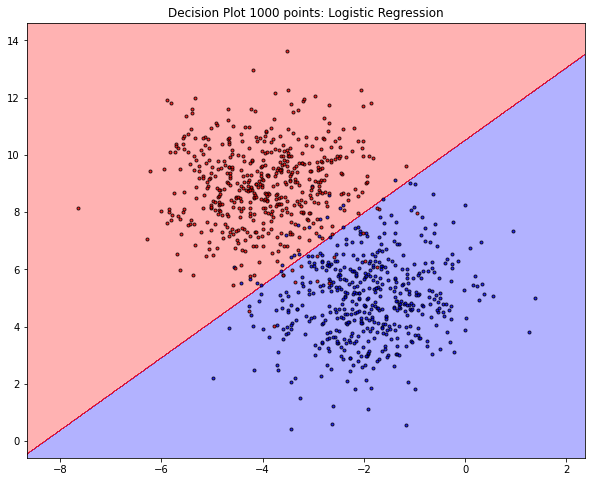

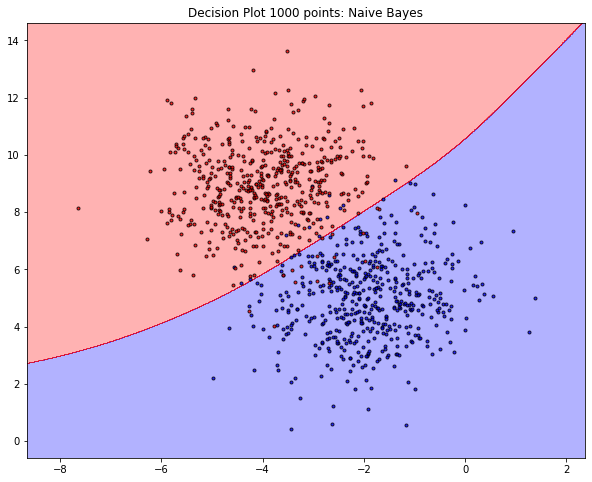

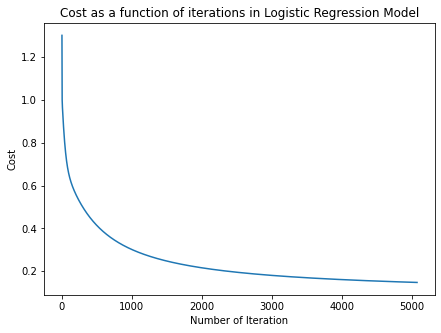

In [23]:
#### Your code here ####
#1: Initialize datasets
train = X_training[:1000,].copy()
Y_train = y_training[:1000,].copy()
test = X_test[:500,]
Y_test = y_test[:500,]


#2: Fitting logistic regression model
LOR = LogisticRegressionGD(features = train, eta=best_eta, eps = best_eps)
LOR.fit(train,Y_train)

#3: Fitting Naive Bayes model- selecting 2 guassians in GMM since there are 2 classes in dataset
NBclass = NaiveBayesGaussian(k=2)
NBclass.fit(train,Y_train)

#4: Run predict on test data and show accuracies
logregaccuracy = accuracy(LOR, test, Y_test)
nbaccuracy = accuracy(NBclass, test, Y_test)
print(f'Logistic regression model accuracy: {np.round(logregaccuracy,4)*100}%')
print(f'Naive Bayes model accuracy: {np.round(nbaccuracy,4)*100}%')

#5: Plot results
plot_decision_regions(X=train, y=Y_train, classifier=LOR)
plt.title('Decision Plot 1000 points: Logistic Regression')
plt.show()

plot_decision_regions(X=train, y=Y_train, classifier=NBclass)
plt.title('Decision Plot 1000 points: Naive Bayes')
plt.show()

#6 
cost = LOR.get_cost_history()
iterations = [i for i in range(len(cost))]
fig, axis = plt.subplots(figsize = (7,5))
plt.plot(iterations, cost)
plt.xlabel('Number of Iteration')
plt.ylabel('Cost')
plt.title('Cost as a function of iterations in Logistic Regression Model')
plt.show()

Logistic regression model accuracy: 71.0%
Naive Bayes model accuracy: 90.3%


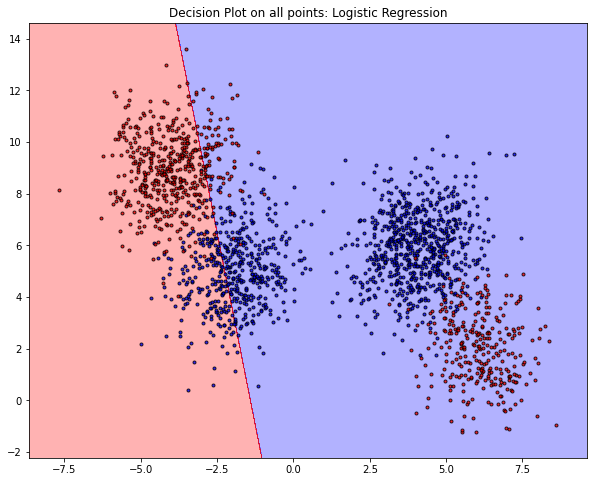

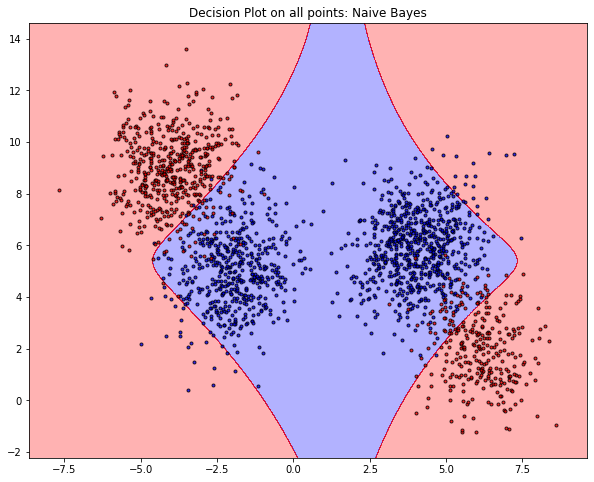

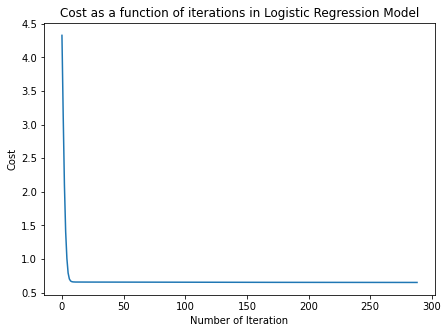

In [24]:
#1: Initialize datasets on all training data
train = X_training
y_tr = y_training
test = X_test
y_tes = y_test

#2: Fitting logistic regression model
classifierall = LogisticRegressionGD(features = train, eta=best_eta, eps = best_eps)
classifierall.fit(train,y_tr)

# #3: Fitting Naive Bayes model- selecting 2 guassians in GMM since there are 2 classes in dataset
NBclass = NaiveBayesGaussian(k=2)
NBclass.fit(X_training,y_training)

#4: Run predict on test data and show accuracies
logregaccuracy = accuracy(classifierall, test, y_tes)
nbaccuracy = accuracy(NBclass, X_test, y_test)
print(f'Logistic regression model accuracy: {np.round(logregaccuracy,4)*100}%')
print(f'Naive Bayes model accuracy: {np.round(nbaccuracy,4)*100}%')

#5: Plot results
plot_decision_regions(X=train, y=y_tr, classifier=classifierall)
plt.title('Decision Plot on all points: Logistic Regression')
plt.show()

plot_decision_regions(X=X_training, y=y_training, classifier=NBclass)
plt.title('Decision Plot on all points: Naive Bayes')
plt.show()

#6 
cost = classifierall.get_cost_history()
iterations = [i for i in range(len(cost))]
fig, axis = plt.subplots(figsize = (7,5))
plt.plot(iterations, cost)
plt.xlabel('Number of Iteration')
plt.ylabel('Cost')
plt.title('Cost as a function of iterations in Logistic Regression Model')
plt.show()

### Observations between 2 models:
The difference between the results


## Open question

(20 points) 

1. In this homework we explored two types of models: Naive Bayes using EM, and Logistic regression.  
    - Generate one dataset that you think Naive Bayes will work better than Logisitc Regression.
    - Generate another dataset that you think Logistic Regression will work better than Naive Bayes using EM.
    - Explain the reasoning behind each dataset.  

(The number of features and instances is up to you, but use only 2 classes)

2. Visualize the datasets like in the beginning of this notebook.

#### Your code and explanations here ####


#### Dataset better performing on Naive Bayes:

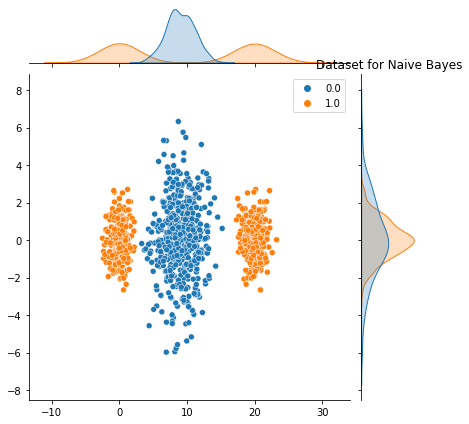

Accuracy of Naive Bayes model on training data: 28.999999999999996%


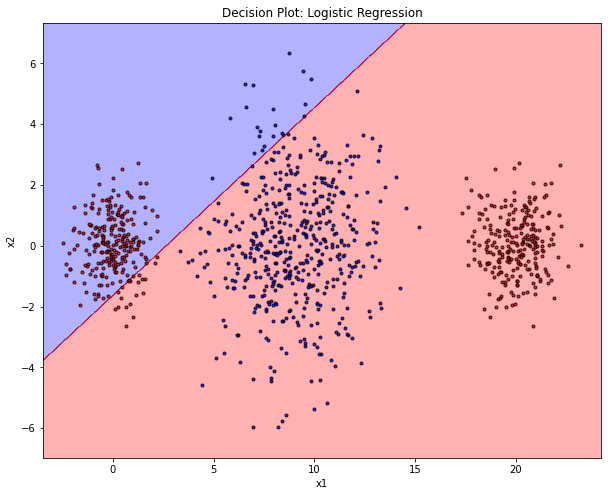

Accuracy of Naive Bayes model on training data: 95.6%


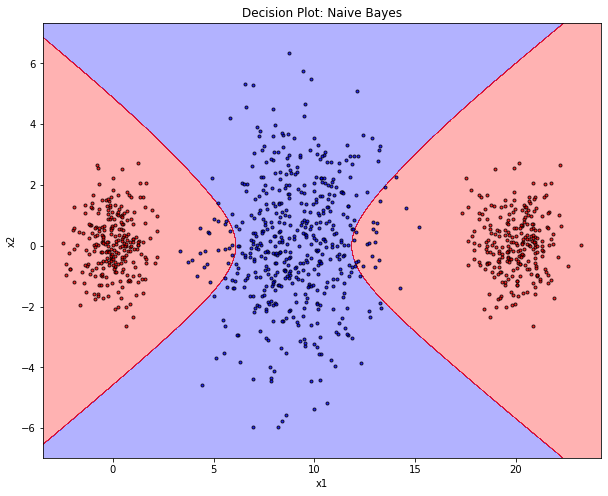

In [70]:
#Dataset 1
n = 250
#Class 0: 1 gaussian , 2 features
class0_G1_x1 = np.random.normal(9, 2, n*2)
class0_G1_x2 = np.random.normal(0, 2, n*2)
y0 = np.zeros(n*2)

#Class 1: 2 gaussians, features
class1_G1_x1 = np.random.normal(0, 1, n)
class1_G1_x2 = np.random.normal(0, 1, n)
class1_G2_x1 = np.random.normal(20, 1, n) 
class1_G2_x2 = np.random.normal(0, 1, n)
class1_x1 = np.hstack((class1a_x1, class1b_x1))
class1_x2 = np.hstack((class1a_x2, class1a_x2))
y1 = np.ones(n*2)

#Both classes
x1 = np.hstack((class0_G1_x1, class1_x1))
x2 = np.hstack((class0_G1_x2, class1_x2))
y = np.hstack((y0, y1))
X = np.column_stack((x1,x2))

sns.jointplot(x1,x2, hue = y)
plt.title('Dataset for Naive Bayes')
plt.show()


# fit logistic regression
LOR = LogisticRegressionGD(features = X, eta = best_eta, eps = best_eps, random_state=1)
LOR.fit(X,y)    
a = accuracy(LOR, X, y)
print(f'Accuracy of Naive Bayes model on training data: {np.round(a,3)*100}%')

plot_decision_regions(X,y, LOR, resolution=0.01)
plt.title('Decision Plot: Logistic Regression')
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

# fit the Naive Bayes model
nb = NaiveBayesGaussian(k=2)
nb.fit(X,y)
a = accuracy(nb, X, y)
print(f'Accuracy of Naive Bayes model on training data: {np.round(a,3)*100}%')

plot_decision_regions(X,y, nb, resolution=0.01)
plt.title('Decision Plot: Naive Bayes')
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()


#### Dataset better performing on Logistic Regression:

   Dataset for Logistic Regression


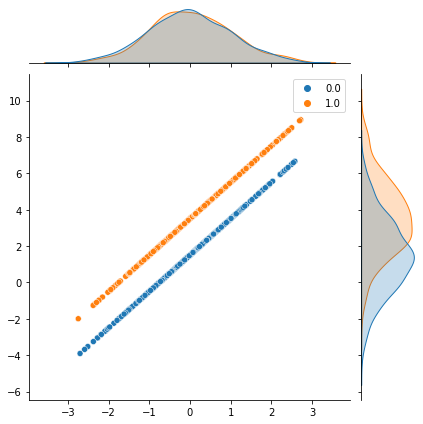

Accuracy of Naive Bayes model on training data: 100.0%


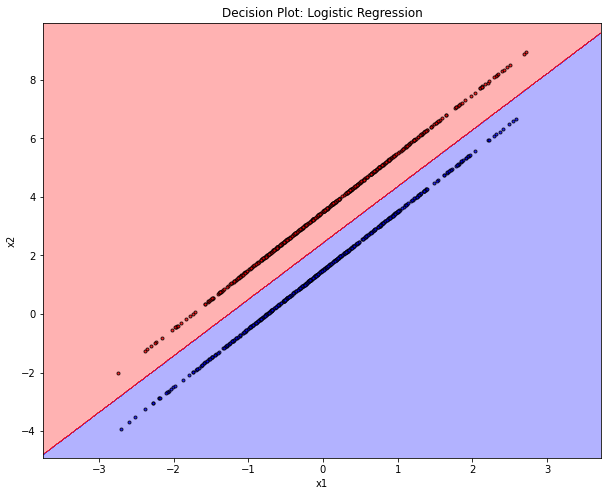

Accuracy of Naive Bayes model on training data: 71.1%


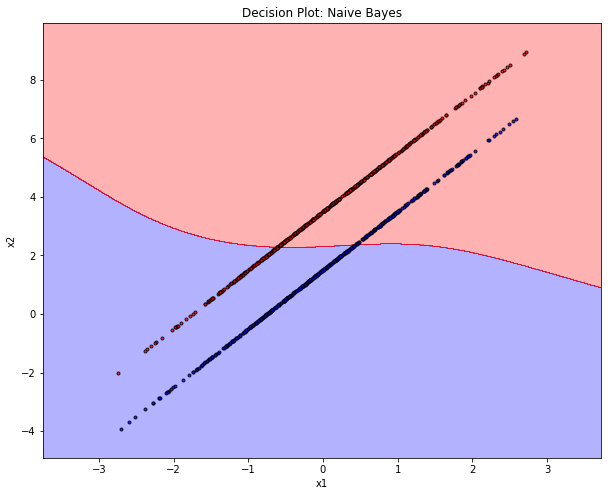

In [81]:
#Dataset 2
n = 500
#Class 0: 
class0_G1_x1 = np.random.normal(0, 1, n)
class0_G1_x2 = [2*x+1.5 for x in class0_G1_x1] 
y0 = np.zeros(n)

#Class 1:
class1_G1_x1 = np.random.normal(0, 1, n)
class1_G1_x2 = [2*x+3.5 for x in class1_G1_x1] 
y1 = np.ones(n)

#Both classes
x1 = np.hstack((class0_G1_x1, class1_G1_x1))
x2 = np.hstack((class0_G1_x2, class1_G1_x2))
y = np.hstack((y0, y1))
X = np.column_stack((x1,x2))

print('   Dataset for Logistic Regression')

sns.jointplot(x1,x2, hue = y)
plt.xlabel('x1')
plt.ylabel('x2')
#plt.title()
plt.show()


# fit logistic regression
LOR = LogisticRegressionGD(features = X, eta = best_eta, eps = best_eps, random_state=1)
LOR.fit(X,y)    
a = accuracy(LOR, X, y)
print(f'Accuracy of Naive Bayes model on training data: {np.round(a,3)*100}%')

plot_decision_regions(X,y, LOR, resolution=0.01)
plt.title('Decision Plot: Logistic Regression')
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

# fit the Naive Bayes model
nb = NaiveBayesGaussian(k=2)
nb.fit(X,y)
a = accuracy(nb, X, y)
print(f'Accuracy of Naive Bayes model on training data: {np.round(a,3)*100}%')

plot_decision_regions(X,y, nb, resolution=0.01)
plt.title('Decision Plot: Naive Bayes')
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

### Discussion
For dataset 1, there is no way to linearly split up the classes in 2D. Since the logistic regression model works as a linear classifier theres is no way it can accuratey split up the 3 blobs into 2 while making a clear distinction in classes. Here is where the Naive Bayed with EM model performs better. It is able to find a non-linear separation. The assumption of the NB model- that the 2 features are conditionally indepdent given class is also upheld and therefore returns good results. 


For dataset 2, the data is built in a way where feature x2 is clearly dependent on x1, in both classes. In addition, the marginal distrubtions of feature x1 per class are the same and as we learned in the recitation, this will give poor results for Naive Bayes. On both k=1 and k=2, we reached a similar accuracy of around 70%. Looking at the decision plot, you can see the prediction is very bad compared to the logistic regression model. Here the logistic regression model works with 100% accuracy as we can see there is away to clearly and distinctly separate the 2 classes. 

